# ClassificationInterpretation normalized

## Current version

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

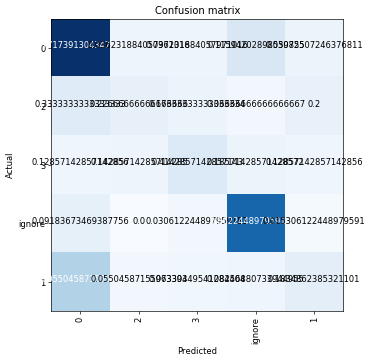

In [16]:
interp.plot_confusion_matrix(figsize=(6,6), dpi=60, normalize=True)

## Pull request

In [17]:
class ClassificationInterpretation2():
    "Interpretation methods for classification models."
    def __init__(self, data:DataBunch, probs:Tensor, y_true:Tensor, losses:Tensor, sigmoid:bool=None):
        if sigmoid is not None: warnings.warn("`sigmoid` argument is deprecated, the learner now always return the probabilities")
        self.data,self.probs,self.y_true,self.losses = data,probs,y_true,losses
        self.pred_class = self.probs.argmax(dim=1)

    @classmethod
    def from_learner(cls, learn:Learner, sigmoid:bool=None, tta=False):
        "Create an instance of `ClassificationInterpretation`. `tta` indicates if we want to use Test Time Augmentation."
        preds = learn.TTA(with_loss=True) if tta else learn.get_preds(with_loss=True)
        return cls(learn.data, *preds, sigmoid=sigmoid)

    def top_losses(self, k:int=None, largest=True):
        "`k` largest(/smallest) losses and indexes, defaulting to all losses (sorted by `largest`)."
        return self.losses.topk(ifnone(k, len(self.losses)), largest=largest)

    def plot_top_losses(self, k, largest=True, figsize=(12,12)):
        "Show images in `top_losses` along with their prediction, actual, loss, and probability of actual class."
        tl_val,tl_idx = self.top_losses(k,largest)
        classes = self.data.classes
        rows = math.ceil(math.sqrt(k))
        fig,axes = plt.subplots(rows,rows,figsize=figsize)
        fig.suptitle('prediction/actual/loss/probability', weight='bold', size=14)
        for i,idx in enumerate(tl_idx):
            t=self.data.valid_ds[idx]
            t[0].show(ax=axes.flat[i], title=
                f'{classes[self.pred_class[idx]]}/{classes[t[1]]} / {self.losses[idx]:.2f} / {self.probs[idx][t[1]]:.2f}')

    def confusion_matrix(self):
        "Confusion matrix as an `np.ndarray`."
        x=torch.arange(0,self.data.c)
        cm = ((self.pred_class==x[:,None]) & (self.y_true==x[:,None,None])).sum(2)
        return to_np(cm)

    def plot_confusion_matrix(self, normalize:bool=False, title:str='Confusion matrix', cmap:Any="Blues", norm_dec:int=2, **kwargs)->None:
        "Plot the confusion matrix, passing `kawrgs` to `plt.figure`."
        # This function is mainly copied from the sklearn docs
        cm = self.confusion_matrix()
        plt.figure(**kwargs)
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        tick_marks = arange_of(self.data.classes)
        plt.xticks(tick_marks, self.data.classes, rotation=90)
        plt.yticks(tick_marks, self.data.classes, rotation=0)

        if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            #plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black") # ORIGINAL
            #plt.text(j, i, "{:.3f}".format(cm[i, j]), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
            plt.text(j, i, f'{cm[i, j]:.{norm_dec}f}', horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
            
        plt.tight_layout()
        plt.ylabel('Actual')
        plt.xlabel('Predicted')

    def most_confused(self, min_val:int=1)->Collection[Tuple[str,str,int]]:
        "Sorted descending list of largest non-diagonal entries of confusion matrix"
        cm = self.confusion_matrix()
        np.fill_diagonal(cm, 0)
        res = [(self.data.classes[i],self.data.classes[j],cm[i,j])
                for i,j in zip(*np.where(cm>min_val))]
        return sorted(res, key=itemgetter(2), reverse=True)




In [18]:
interp2 = ClassificationInterpretation2.from_learner(learn)

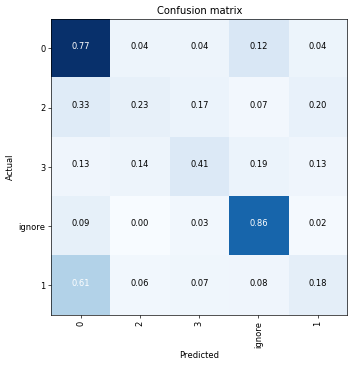

In [19]:
interp2.plot_confusion_matrix(figsize=(6,6), dpi=60, normalize=True)